# Imports

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib import cm
import seaborn as sns
import folium

# Overall analysis of Uber rides from April-September 2014

## Data Loading, Preparation and Visualization 

Load the data of each month into a DataFrame and concatenate into a single one.

In [8]:
df_apr14 = pd.read_csv('./data/uber-raw-data-apr14.csv')
df_may14 = pd.read_csv('./data/uber-raw-data-may14.csv')
df_jun14 = pd.read_csv('./data/uber-raw-data-jun14.csv')
df_jul14 = pd.read_csv('./data/uber-raw-data-jul14.csv')
df_aug14 = pd.read_csv('./data/uber-raw-data-aug14.csv')
df_sep14 = pd.read_csv('./data/uber-raw-data-sep14.csv')

df = pd.concat([df_apr14,df_may14,df_jun14,df_jul14,df_aug14,df_sep14])

Check for missing values and the data types of each category.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4534327 entries, 0 to 1028135
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 173.0+ MB


Perform a quick dataset description to check for the mean lattitude and longitude values, as well as other values.

In [10]:
df.describe()

Lat           Lon
count  4.534327e+06  4.534327e+06
mean   4.073926e+01 -7.397302e+01
std    3.994991e-02  5.726670e-02
min    3.965690e+01 -7.492900e+01
25%    4.072110e+01 -7.399650e+01
50%    4.074220e+01 -7.398340e+01
75%    4.076100e+01 -7.396530e+01
max    4.211660e+01 -7.206660e+01

Separate the day and time into seperate categories (month-day-weekday-hour.)

In [11]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

df['month'] = df['Date/Time'].dt.month
df['day'] = df['Date/Time'].dt.day
df['weekday'] = df['Date/Time'].dt.weekday
df['hour'] = df['Date/Time'].dt.hour

df

Date/Time      Lat      Lon    Base  month  day  weekday  \
0       2014-04-01 00:11:00  40.7690 -73.9549  B02512      4    1        1   
1       2014-04-01 00:17:00  40.7267 -74.0345  B02512      4    1        1   
2       2014-04-01 00:21:00  40.7316 -73.9873  B02512      4    1        1   
3       2014-04-01 00:28:00  40.7588 -73.9776  B02512      4    1        1   
4       2014-04-01 00:33:00  40.7594 -73.9722  B02512      4    1        1   
...                     ...      ...      ...     ...    ...  ...      ...   
1028131 2014-09-30 22:57:00  40.7668 -73.9845  B02764      9   30        1   
1028132 2014-09-30 22:57:00  40.6911 -74.1773  B02764      9   30        1   
1028133 2014-09-30 22:58:00  40.8519 -73.9319  B02764      9   30        1   
1028134 2014-09-30 22:58:00  40.7081 -74.0066  B02764      9   30        1   
1028135 2014-09-30 22:58:00  40.7140 -73.9496  B02764      9   30        1   

         hour  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
1028131    22  
1028132    22  
1028133    22  
1028134    22  
1028135    22  

[4534327 rows x 8 columns]

## Data Analysis and Exploration

### 1.1 Number of Uber rides per Hour.

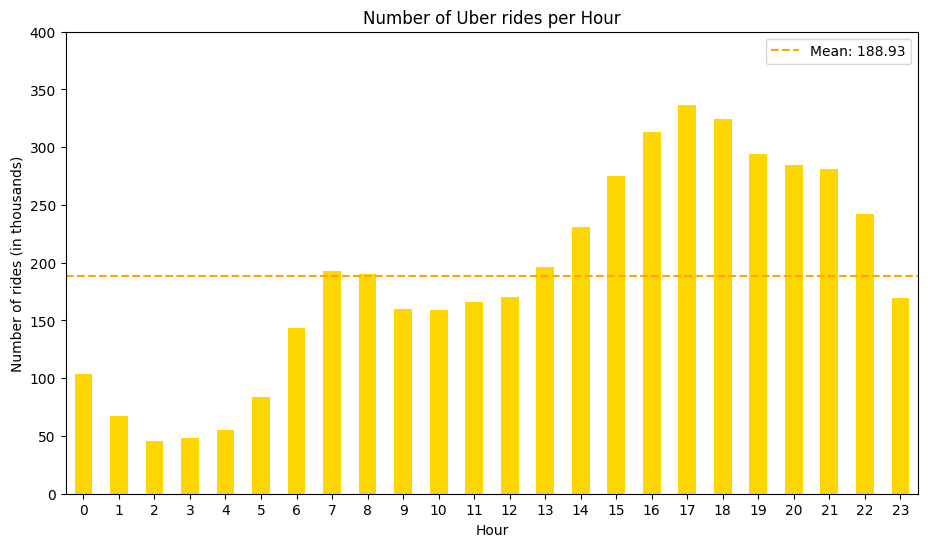

In [12]:
hours_counts = df['hour'].value_counts(sort=False)
hours_counts_mean = hours_counts.sum()/df['hour'].nunique()

plt.figure(figsize=(11,6))
hours_counts.plot(kind='bar', color='gold')
mean_line = plt.axhline(hours_counts_mean, color='orange', linestyle='--', label=f'Mean: {hours_counts_mean/1000:.2f}')
plt.xlabel('Hour')
plt.ylabel('Number of rides (in thousands)')
plt.title('Number of Uber rides per Hour')
ticks = plt.gca().get_yticks()
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels([int(label / 1000) for label in ticks])
plt.xticks(rotation=0)
plt.legend(handles=[mean_line])
plt.savefig('results/figures/uber_rides_per_hour.pdf', format='pdf')

plt.show()

### 1.2 Number of Uber rides per Day of the Week.

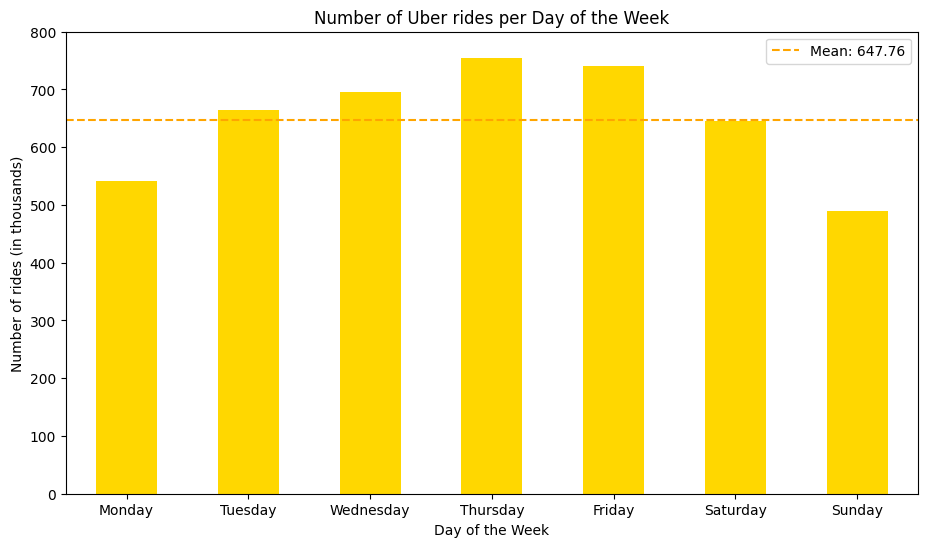

In [13]:
weekdays_counts = df['weekday'].value_counts(sort=False)

weekdays_counts_sorted = weekdays_counts.sort_index()
weekdays_dict = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

weekdays_counts_sorted_named = weekdays_counts_sorted.rename(index=weekdays_dict).reindex(list(weekdays_dict.values()))
weekdays_counts_mean = weekdays_counts.sum()/df['weekday'].nunique()

plt.figure(figsize=(11,6))
weekdays_counts_sorted_named.plot(kind='bar', color='gold')
mean_line = plt.axhline(weekdays_counts_mean, color='orange', linestyle='--', label=f'Mean: {weekdays_counts_mean/1000:.2f}')
plt.xlabel('Day of the Week')
plt.ylabel('Number of rides (in thousands)')
plt.title('Number of Uber rides per Day of the Week')
ticks = plt.gca().get_yticks()
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels([int(label / 1000) for label in ticks])
plt.legend(handles=[mean_line])
plt.xticks(rotation=0)
plt.savefig('results/figures/uber_rides_per_weekday.pdf', format='pdf')

plt.show()

### 1.3 Number of Uber rides per day in Weekdays vs Weekends.

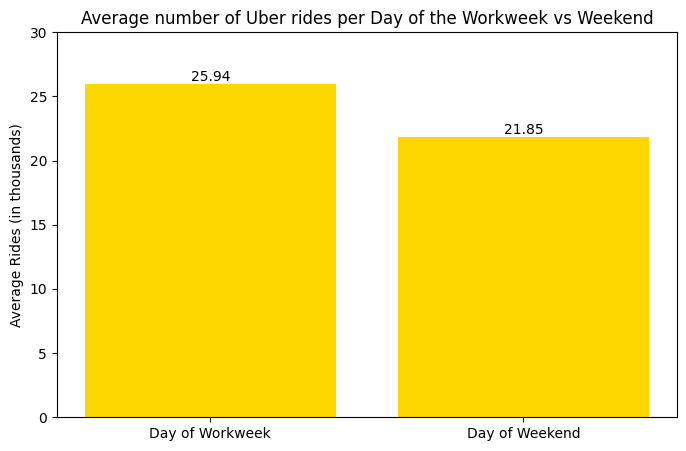

In [14]:
total_rides_weekdays = weekdays_counts_sorted.loc[[0,1,2,3,4]].sum()
total_rides_weekends = weekdays_counts_sorted.loc[[5,6]].sum()

weekends = df[df['weekday'].isin([5, 6])]
unique_weekends_count = weekends[['month', 'day']].drop_duplicates().shape[0]
average_per_weekend = total_rides_weekends/unique_weekends_count

weekdays = df[df['weekday'].isin([0,1,2,3,4])]
unique_weedays_count = weekdays[['month', 'day']].drop_duplicates().shape[0]
average_per_weekday = total_rides_weekdays/unique_weedays_count


categories = ['Day of Workweek', 'Day of Weekend']
values = [average_per_weekday, average_per_weekend]
plt.figure(figsize=(8, 5))
bars = plt.bar(categories, values, color='gold')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height/1000:.2f}',
             ha='center', va='bottom', fontsize=10)

plt.title('Average number of Uber rides per Day of the Workweek vs Weekend')
ticks = plt.gca().get_yticks()
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels([int(label / 1000) for label in ticks])
plt.ylabel('Average Rides (in thousands)')
plt.savefig('results/figures/uber_rides_weekday_vs_weekends.pdf', format='pdf')

plt.show()

This comparison is fair, as it accounts for the shorter duration of the weekend compared to the workweek. From the results, we can conclude that the average number of rides on weekdays surpasses that of weekends by approximately 4,000 rides per day. This notable difference highlights the higher demand for Uber rides during weekdays.

# Comparison analysis between Uber rides from April-September 2014

Since the datasets used here as the same as the ones used in the previous section, we will omit the "Data Loading, Preparation and Visualization" step. 

Refer to "Data Loading, Preparation and Visualization" of "Overall analysis of Uber rides from April-September 2014".

## Data Analysis and Exploration

### 2.1 Number of Uber rides per Month

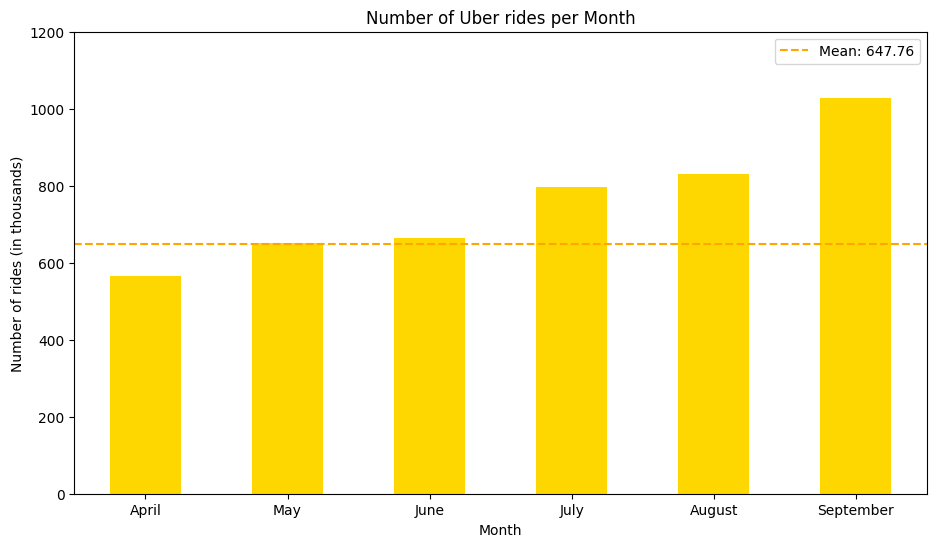

In [15]:
month_counts = df['month'].value_counts(sort=False)

month_dict = {
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
}

month_counts_named = month_counts.rename(index=month_dict).reindex(list(month_dict.values()))
month_counts_mean = weekdays_counts.sum()/df['weekday'].nunique()

plt.figure(figsize=(11,6))
month_counts_named.plot(kind='bar', color='gold')
mean_line = plt.axhline(month_counts_mean, color='orange', linestyle='--', label=f'Mean: {month_counts_mean/1000:.2f}')
plt.xlabel('Month')
plt.ylabel('Number of rides (in thousands)')
plt.title('Number of Uber rides per Month')
plt.xticks(rotation=0)
ticks = plt.gca().get_yticks()
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels([int(label / 1000) for label in ticks])
plt.legend(handles=[mean_line])
plt.savefig('results/figures/uber_rides_per_month.pdf', format='pdf')

plt.show()

### 2.2 Number of Uber rides per Hour and Month

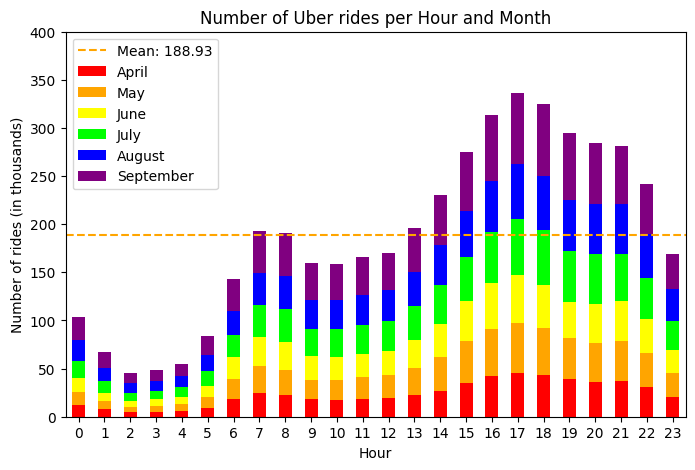

In [16]:
df_hour_month_grouped = df.groupby(['hour','month']).size().unstack(fill_value=0)

df_hour_month_grouped_named = df_hour_month_grouped.rename(columns=month_dict)


fig, ax = plt.subplots(figsize=(8, 5))
df_hour_month_grouped_named.plot(kind='bar', color=['red', 'orange', 'yellow', 'lime', 'blue', 'purple'], stacked=True, ax=ax)
mean_line = ax.axhline(hours_counts_mean, color='orange', linestyle='--', label=f'Mean: {hours_counts_mean/1000:.2f}')
ax.set_xlabel('Hour')
ax.set_ylabel('Number of rides (in thousands)')
ax.set_title('Number of Uber rides per Hour and Month')
ticks = ax.get_yticks()
ax.set_yticks(ticks)
ax.set_yticklabels([int(label / 1000) for label in ax.get_yticks()])
ax.set_xticks(range(len(df_hour_month_grouped_named)))
ax.set_xticklabels(df_hour_month_grouped_named.index, rotation=0)
ax.legend()
plt.savefig('results/figures/uber_rides_per_hour_and_month.pdf', format='pdf')

plt.show()

### 2.3 Number of Uber rides per Day of the Week and Month

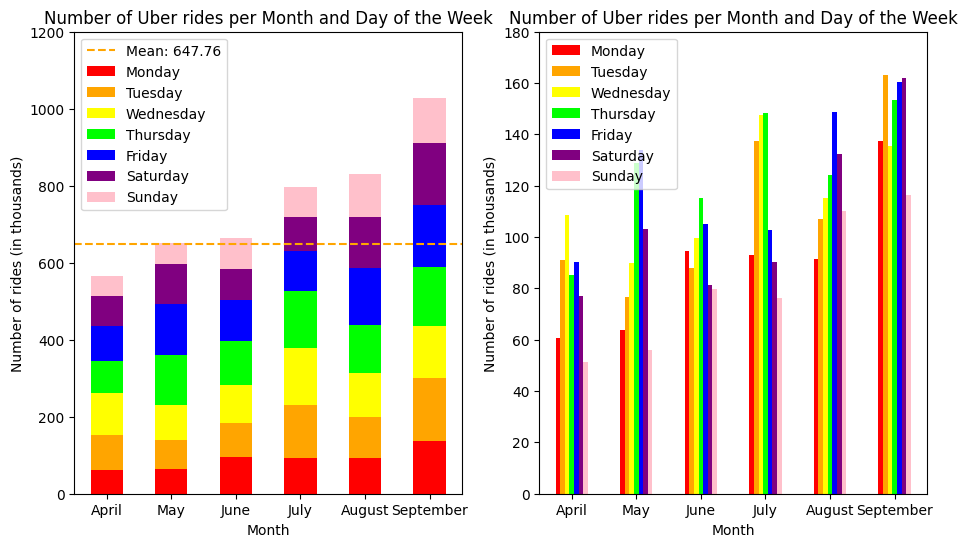

In [17]:
df_weekday_month_grouped = df.groupby(['month','weekday']).size().unstack(fill_value=0)
df_weekday_month_grouped_named = df_weekday_month_grouped.rename(columns=weekdays_dict,index=month_dict)

fig, ax = plt.subplots(1, 2, figsize=(11, 6))
df_weekday_month_grouped_named.plot(kind='bar', color=['red', 'orange', 'yellow', 'lime', 'blue', 'purple', 'pink'], stacked=True, ax=ax[0])
mean_line = ax[0].axhline(weekdays_counts_mean, color='orange', linestyle='--', label=f'Mean: {weekdays_counts_mean/1000:.2f}')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of rides (in thousands)')
ax[0].set_title('Number of Uber rides per Month and Day of the Week')
ticks = ax[0].get_yticks()
ax[0].set_yticks(ticks)
ax[0].set_yticklabels([int(label / 1000) for label in ax[0].get_yticks()])
ax[0].set_xticks(range(len(df_weekday_month_grouped_named)))
ax[0].set_xticklabels(df_weekday_month_grouped_named.index, rotation=0)
ax[0].legend()

df_weekday_month_grouped_named.plot(kind='bar', color=['red', 'orange', 'yellow', 'lime', 'blue', 'purple', 'pink'], stacked=False, ax=ax[1])
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Number of rides (in thousands)')
ax[1].set_title('Number of Uber rides per Month and Day of the Week')
ticks = ax[1].get_yticks()
ax[1].set_yticks(ticks)
ax[1].set_yticklabels([int(label / 1000) for label in ax[1].get_yticks()])
ax[1].set_xticks(range(len(df_weekday_month_grouped_named)))
ax[1].set_xticklabels(df_weekday_month_grouped_named.index, rotation=0)
ax[1].legend()
plt.savefig('results/figures/uber_rides_per_weekday_and_month.pdf', format='pdf')

plt.show()

The busiest day of the week for rides changes each month (April: Wednesday; May: Friday; June: Thursday; July: Thursday; August: Friday; September: Tuesday). This variability highlights that each month's pattern differs substantially. While Section 1.2 shows Thursday as the overall busiest day, followed by Friday and Wednesday, this general trend does not align with the each monthly patterns, highlighting the inconsistency across months.

# Comparison analysis between Uber rides inside and outside of Manhattan

## Data Loading, Preparation and Visualization

We define approximate boundaries for the Manhattan area and create a new column to indicate whether each ride occurred inside or outside of Manhattan.

In [18]:
#Approximated manhattan boundaries
manhattan_bounds = {
    'lat_min': 40.700081,
    'lat_max': 40.806410,
    'lon_min': -74.013846,
    'lon_max':  -73.953250
}

df['is_manhattan'] = (
    (df['Lat'] > manhattan_bounds['lat_min']) & 
    (df['Lat'] < manhattan_bounds['lat_max']) & 
    (df['Lon'] > manhattan_bounds['lon_min']) & 
    (df['Lon'] < manhattan_bounds['lon_max'])
)

## Data Analysis and Exploration

Create a scatter plot of a small sample of the locations where Uber pickups occurred. This can help visualize better if there are any areas where rides happen most often.

In [19]:
sample_df = df.sample(n=5000, random_state= np.random.seed())

nyc_map = folium.Map(
    max_bounds=True,
    location=[sample_df['Lat'].mean(), sample_df['Lon'].mean()], 
    zoom_start=12,
    min_lat=sample_df['Lat'].min(),
    min_lon=sample_df['Lon'].min(),
    max_lat=sample_df['Lat'].max(),
    max_lon=sample_df['Lon'].max()
)

marker_group = folium.FeatureGroup(name="Pickups")

for _, row in sample_df.iterrows():
    folium.CircleMarker(
        location=[row['Lat'], row['Lon']],
        radius=1,
        color='blue',
        fill=True,
        fill_opacity=0.5
    ).add_to(marker_group)

# Add the marker group to the map
marker_group.add_to(nyc_map)
40.806410

manhattan_bounds = {
    'lat_min': 40.700081,
    'lat_max': 40.806410,
    'lon_min': -74.013846,
    'lon_max':  -73.953250
}

folium.CircleMarker([manhattan_bounds['lat_max'], manhattan_bounds['lon_min']], 
                    tooltip="Top-left Corner of Manhattan").add_to(nyc_map)
folium.CircleMarker([manhattan_bounds['lat_min'], manhattan_bounds['lon_min']], 
                    tooltip="Bottom-left Corner of Manhattan").add_to(nyc_map)
folium.CircleMarker([manhattan_bounds['lat_min'], manhattan_bounds['lon_max']], 
                    tooltip="Bottom-right Corner of Manhattan").add_to(nyc_map)
folium.CircleMarker([manhattan_bounds['lat_max'], manhattan_bounds['lon_max']], 
                    tooltip="Top-right Corner of Manhattan").add_to(nyc_map)


# Display the map
nyc_map

### 3.1 Percentage of Uber rides inside and outside of Manhattan

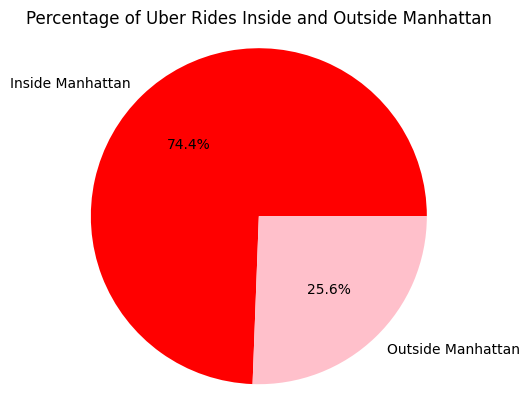

In [20]:
manhattan_rides_count = df['is_manhattan'].sum()
non_manhattan_rides_count = (~df['is_manhattan']).sum()

plt.pie([manhattan_rides_count,non_manhattan_rides_count], labels=['Inside Manhattan','Outside Manhattan'], colors=['red','pink'],autopct='%1.1f%%')
plt.axis('equal')
plt.title('Percentage of Uber Rides Inside and Outside Manhattan')
plt.savefig('results/figures/uber_rides_per_zone.pdf', format='pdf')

plt.show()

### 3.2 Number of Uber rides per Hour and Zone.


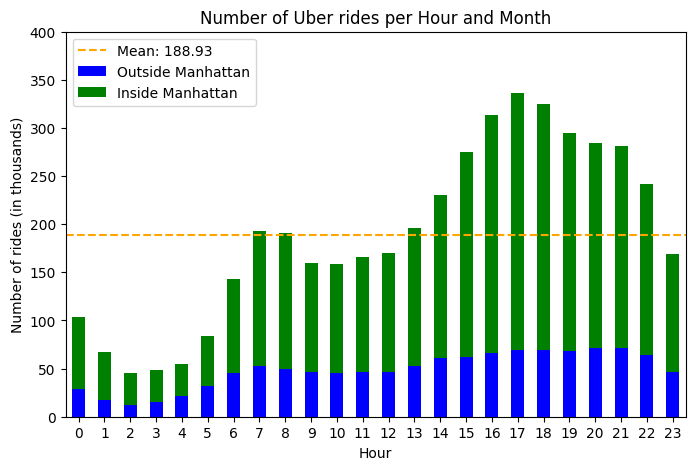

In [21]:
manhattan_dict = {True: 'Inside Manhattan',
                  False: 'Outside Manhattan'}

df_hour_manhattan_grouped = df.groupby(['hour', 'is_manhattan']).size().unstack(fill_value=0)
df_hour_manhattan_grouped_named = df_hour_manhattan_grouped.rename(columns=manhattan_dict)

fig, ax = plt.subplots(figsize=(8, 5))

df_hour_manhattan_grouped_named.plot(kind='bar', color=['blue', 'green'], stacked=True, ax=ax)

mean_line = ax.axhline(hours_counts_mean, color='orange', linestyle='--', label=f'Mean: {hours_counts_mean/1000:.2f}')

ax.set_xlabel('Hour')
ax.set_ylabel('Number of rides (in thousands)')
ax.set_title('Number of Uber rides per Hour and Month')

ticks = ax.get_yticks()
ax.set_yticks(ticks)
ax.set_yticklabels([int(label / 1000) for label in ax.get_yticks()])
ax.set_xticks(range(len(df_hour_manhattan_grouped_named)))
ax.set_xticklabels(df_hour_manhattan_grouped_named.index, rotation=0)
ax.legend()
plt.savefig('results/figures/uber_rides_per_zone_and_hour.pdf', format='pdf')

plt.show()

To complement the previous plot, we can construct a table showing the percentage of Uber rides for each zone per hour.

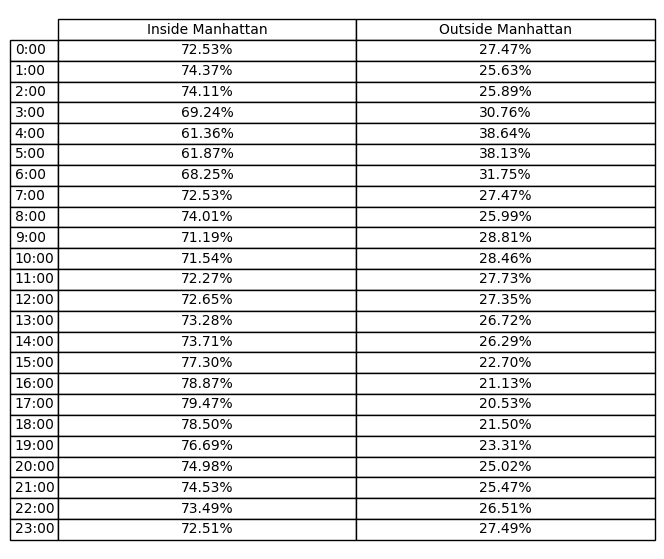

In [22]:
df_hour_manhattan_percentage = df_hour_manhattan_grouped_named.div(df_hour_manhattan_grouped_named.sum(axis=1), axis=0) * 100
table_data = df_hour_manhattan_percentage[['Inside Manhattan', 'Outside Manhattan']].round(2)

formatted_table_data = table_data.map(lambda x: f"{x:.2f}%")

custom_row_labels = [f"{i}:00" for i in range(0, len(formatted_table_data))]

fig, ax = plt.subplots(figsize=(7, 7))
ax.axis('off')

table = plt.table(cellText=formatted_table_data.values, 
                  colLabels=formatted_table_data.columns, 
                  rowLabels=custom_row_labels, 
                  loc='center', cellLoc='center', colLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.1, 1.25)
plt.savefig('results/figures/table_uber_rides_per_zone_and_hour.pdf', format='pdf')

plt.show()

At every hour of the day, the number of rides in Manhattan exceeds those outside it. The largest gap occurs at 5 p.m., with rides in Manhattan making up about 80% of all rides recorded at that time. Conversely, the smallest share happens during the early morning hours (4 AM and 5 AM), when rides in Manhattan drop to around 62%.

# Comparison analysis between Uber and other FHV companies from July-September 2014

## Data Loading, Preparation and Visualization 

Load every dataset needed and prepare the data of each dataset individually

In [54]:
df_jul14 = pd.read_csv('./data/uber-raw-data-jul14.csv')
df_aug14 = pd.read_csv('./data/uber-raw-data-aug14.csv')
df_sep14 = pd.read_csv('./data/uber-raw-data-sep14.csv')

df_uber = pd.concat([df_jul14,df_aug14,df_sep14])

df_american = pd.read_csv('./data/other-American_B01362.csv', encoding='latin1')
df_highclass = pd.read_csv('./data/other-Highclass_B01717.csv', encoding='latin1')
df_skyline = pd.read_csv('./data/other-Skyline_B00111.csv', encoding='latin1')
df_caramel = pd.read_csv('./data/other-Carmel_B00256.csv', encoding='latin1')
df_lyft = pd.read_csv('./data/other-Lyft_B02510.csv', encoding='latin1')
df_dial7 = pd.read_csv('./data/other-Dial7_B00887.csv', encoding='latin1')
df_firstclass = pd.read_csv('./data/other-Firstclass_B01536.csv', encoding='latin1')
df_prestige = pd.read_csv('./data/other-Prestige_B01338.csv', encoding='latin1')

Individually preparation of the data for each FHV company dataset, starting with Uber.

In [55]:
df_uber = df_uber[['Date/Time']]
df_uber['Date/Time'] = pd.to_datetime(df_uber['Date/Time'])
df_uber['day'] = df_uber['Date/Time'].dt.date
df_uber['hour'] = df_uber['Date/Time'].dt.hour
df_uber = df_uber.drop(columns=['Date/Time'])
df_uber['company'] = 'uber'
df_uber

day  hour company
0        2014-07-01     0    uber
1        2014-07-01     0    uber
2        2014-07-01     0    uber
3        2014-07-01     0    uber
4        2014-07-01     0    uber
...             ...   ...     ...
1028131  2014-09-30    22    uber
1028132  2014-09-30    22    uber
1028133  2014-09-30    22    uber
1028134  2014-09-30    22    uber
1028135  2014-09-30    22    uber

[2653532 rows x 3 columns]

American

In [56]:
df_american['DATE'] = pd.to_datetime(df_american['DATE'], format='%m/%d/%Y', errors='coerce')
df_american['TIME'] = df_american['TIME'].str.strip()

df_american['TIME'] = pd.to_datetime(df_american['TIME'], format='%I:%M:%S %p', errors='coerce').dt.hour

df_american = df_american[['DATE','TIME']]
df_american.columns = ['day', 'hour']
df_american['company'] = 'american'
df_american

day  hour   company
0     2014-07-01     0  american
1     2014-07-01     0  american
2     2014-07-01     0  american
3     2014-07-01     0  american
4     2014-07-01     0  american
...          ...   ...       ...
91707 2014-09-30    23  american
91708 2014-09-30    23  american
91709 2014-09-30    23  american
91710 2014-09-30    23  american
91711 2014-09-30    23  american

[91712 rows x 3 columns]

Highclass

In [57]:
df_highclass['DATE'] = pd.to_datetime(df_highclass['DATE'], format='%m/%d/%Y', errors='coerce')
df_highclass['TIME'] = df_highclass['TIME'].str.strip()

df_highclass['TIME'] = pd.to_datetime(df_highclass['TIME'], format='%I:%M:%S %p', errors='coerce').dt.hour

df_highclass = df_highclass[['DATE','TIME']]
df_highclass.columns = ['day', 'hour']
df_highclass['company'] = 'highclass'

df_highclass

day  hour    company
0      2014-07-01     0  highclass
1      2014-07-01     0  highclass
2      2014-07-01     0  highclass
3      2014-07-01     0  highclass
4      2014-07-01     0  highclass
...           ...   ...        ...
151920 2014-09-30    23  highclass
151921 2014-09-30    23  highclass
151922 2014-09-30    23  highclass
151923 2014-09-30    23  highclass
151924 2014-09-30    23  highclass

[151925 rows x 3 columns]

Skyline

In [58]:
df_skyline['Date'] = pd.to_datetime(df_skyline['Date'], format='%m/%d/%Y', errors='coerce')
df_skyline['Time'] = df_skyline['Time'].str.strip()

df_skyline['Time'] = pd.to_datetime(df_skyline['Time'], format='%H:%M', errors='coerce').dt.hour

df_skyline = df_skyline[['Date','Time']]
df_skyline.columns = ['day', 'hour']
df_skyline['company'] = 'skyline'
df_skyline

day  hour  company
0      2014-07-01    20  skyline
1      2014-07-01    21  skyline
2      2014-07-01    22  skyline
3      2014-07-01    12  skyline
4      2014-07-01    16  skyline
...           ...   ...      ...
127691 2014-09-29    13  skyline
127692 2014-09-29    15  skyline
127693 2014-09-29    20  skyline
127694 2014-09-29    22  skyline
127695 2014-09-29    16  skyline

[127696 rows x 3 columns]

Caramel

In [59]:
df_caramel['Date'] = pd.to_datetime(df_caramel['Date'], format='%m/%d/%Y', errors='coerce')
df_caramel['Time'] = df_caramel['Time'].str.strip()

df_caramel['Time'] = pd.to_datetime(df_caramel['Time'], format='%H:%M', errors='coerce').dt.hour

df_caramel = df_caramel[['Date','Time']]
df_caramel.columns = ['day', 'hour']
df_caramel['company'] = 'caramel'
df_caramel

day  hour  company
0      2014-07-01     0  caramel
1      2014-07-01     0  caramel
2      2014-07-01     0  caramel
3      2014-07-01     0  caramel
4      2014-07-01     0  caramel
...           ...   ...      ...
256514 2014-09-30    23  caramel
256515 2014-09-30    23  caramel
256516 2014-09-30    23  caramel
256517 2014-09-30    23  caramel
256518 2014-09-30    23  caramel

[256519 rows x 3 columns]

Lyft

In [60]:
df_lyft['day'] = pd.to_datetime(df_lyft['time_of_trip'], format='%m/%d/%Y %H:%M', errors='coerce').dt.date
df_lyft['time_of_trip'] = df_lyft['time_of_trip'].str.strip()

df_lyft['hour'] = pd.to_datetime(df_lyft['time_of_trip'], format='%m/%d/%Y %H:%M', errors='coerce').dt.hour
df_lyft = df_lyft[['day','hour']]
df_lyft['company'] = 'lyft'
df_lyft

day  hour company
0       2014-09-04     9    lyft
1       2014-08-27    21    lyft
2       2014-09-04    14    lyft
3       2014-09-04    16    lyft
4       2014-08-28     2    lyft
...            ...   ...     ...
267696  2014-09-07     3    lyft
267697  2014-09-07     2    lyft
267698  2014-09-07     1    lyft
267699  2014-09-05    23    lyft
267700  2014-09-06    22    lyft

[267701 rows x 3 columns]

Dial7

In [61]:
df_dial7['Date'] = pd.to_datetime(df_dial7['Date'], format='%Y.%m.%d', errors='coerce').dt.date
df_dial7['Time'] = df_dial7['Time'].str.strip()

df_dial7['Time'] = pd.to_datetime(df_dial7['Time'], format='%H:%M', errors='coerce').dt.hour

df_dial7 = df_dial7[['Date','Time']]
df_dial7.columns = ['day', 'hour']
df_dial7['company'] = 'dial7'

df_dial7

day  hour company
0       2014-07-06    14   dial7
1       2014-07-04     7   dial7
2       2014-07-05     5   dial7
3       2014-07-06     4   dial7
4       2014-07-05     7   dial7
...            ...   ...     ...
194987  2014-09-28    21   dial7
194988  2014-09-28     7   dial7
194989  2014-09-28    15   dial7
194990  2014-09-28    19   dial7
194991  2014-09-08     9   dial7

[194992 rows x 3 columns]

Firstclass

In [62]:
df_firstclass['DATE'] = pd.to_datetime(df_firstclass['DATE'], format='%m/%d/%Y', errors='coerce')
df_firstclass['TIME'] = df_firstclass['TIME'].str.strip()

df_firstclass['TIME'] = pd.to_datetime(df_firstclass['TIME'], format='%I:%M:%S %p', errors='coerce').dt.hour

df_firstclass = df_firstclass[['DATE','TIME']]
df_firstclass.columns = ['day', 'hour']
df_firstclass['company'] = 'firstclass'

df_firstclass

day  hour     company
0      2014-07-01     0  firstclass
1      2014-07-01     0  firstclass
2      2014-07-01     0  firstclass
3      2014-07-01     0  firstclass
4      2014-07-01     0  firstclass
...           ...   ...         ...
166764 2014-09-30    23  firstclass
166765 2014-09-30    23  firstclass
166766 2014-09-30    23  firstclass
166767 2014-09-30    23  firstclass
166768 2014-09-30    23  firstclass

[166769 rows x 3 columns]

Prestige

In [63]:
df_prestige['DATE'] = pd.to_datetime(df_prestige['DATE'], format='%m/%d/%Y', errors='coerce')
df_prestige['TIME'] = df_prestige['TIME'].str.strip()

df_prestige['TIME'] = pd.to_datetime(df_prestige['TIME'], format='%I:%M:%S %p', errors='coerce').dt.hour

df_prestige = df_prestige[['DATE','TIME']]
df_prestige.columns = ['day', 'hour']
df_prestige['company'] = 'prestige'

df_prestige

day  hour   company
0      2014-07-01     0  prestige
1      2014-07-01     0  prestige
2      2014-07-01     0  prestige
3      2014-07-01     0  prestige
4      2014-07-01     0  prestige
...           ...   ...       ...
320636 2014-09-30    23  prestige
320637 2014-09-30    23  prestige
320638 2014-09-30    23  prestige
320639 2014-09-30    23  prestige
320640 2014-09-30    23  prestige

[320641 rows x 3 columns]

Concatenate all DataFrames into one

In [64]:
df = pd.concat([df_uber,df_american,df_highclass,df_skyline,df_caramel,df_lyft,df_dial7,df_firstclass,df_prestige])

## Data Analysis and Exploration

### 4.1 Number of rides per Company

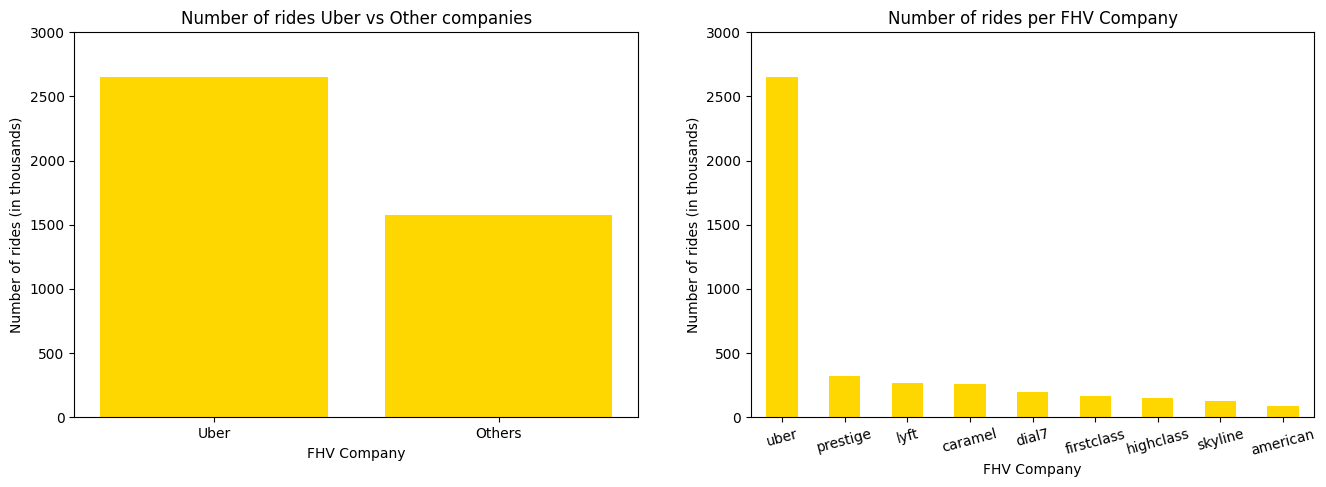

In [65]:
company_counts = df['company'].value_counts()
uber_non_uber_count = [company_counts.loc[company_counts.index == 'uber'].sum(), company_counts.loc[company_counts.index != 'uber'].sum()]

fig, ax = plt.subplots(1, 2, figsize=(16,5))

ax[0].bar(['Uber','Others'], uber_non_uber_count, color='gold')
ax[0].set_xlabel('FHV Company')
ax[0].set_ylabel('Number of rides (in thousands)')
ax[0].set_title('Number of rides Uber vs Other companies')
ticks = ax[0].get_yticks()
ax[0].set_yticks(ticks)
ax[0].set_yticklabels([int(label / 1000) for label in ax[0].get_yticks()])

company_counts.plot(kind='bar', color='gold', ax=ax[1])
ax[1].set_xlabel('FHV Company')
ax[1].set_ylabel('Number of rides (in thousands)')
ax[1].set_title('Number of rides per FHV Company')
ticks = ax[1].get_yticks()
ax[1].set_yticks(ticks)
ax[1].set_yticklabels([int(label / 1000) for label in ax[1].get_yticks()])
ax[1].set_xticks(range(len(company_counts)))
ax[1].set_xticklabels(company_counts.index, rotation=15)
plt.savefig('results/figures/fhv_companies_rides.pdf', format='pdf')

plt.show()

Uber dominated the FHV market in New York between July and September 2014, completing about 2.5 million rides. In comparison, all other FHV companies combined accounted for around 1.5 million rides—nearly 1 million fewer than Uber. Among these companies, Prestige led the pack, followed by Lyft and Caramel. However, Lyft's lack of data for July slightly skews the comparison.

### 4.2 Number of rides per Month and Company

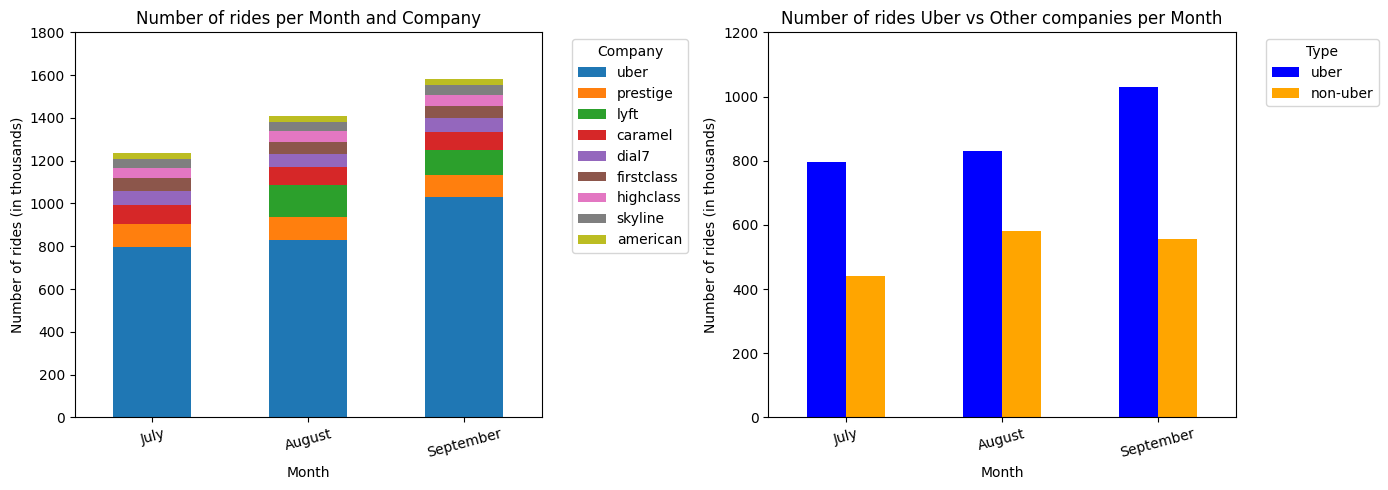

In [66]:
month_dict = {
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
}

df.loc[df['company'] == 'uber', 'is-uber'] = 'uber'
df.loc[df['company'] != 'uber', 'is-uber'] = 'non-uber'
df['month'] = pd.to_datetime(df['day'], format='%Y-%m-%d', errors='coerce').dt.month

stacked_data = df.groupby(['month', 'company']).size().unstack(fill_value=0)
stacked_data = stacked_data[stacked_data.sum(axis=0).sort_values(ascending=False).index]
non_stacked_data = df.groupby(['month', 'is-uber']).size().unstack(fill_value=0)
non_stacked_data = non_stacked_data[non_stacked_data.sum(axis=0).sort_values(ascending=False).index]

stacked_data.rename(columns=month_dict, inplace=True)
non_stacked_data.rename(columns=month_dict, inplace=True)
stacked_data.index = stacked_data.index.map(month_dict)
non_stacked_data.index = non_stacked_data.index.map(month_dict)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

stacked_data.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_title("Number of rides per Month and Company")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Number of rides (in thousands)")
ax[0].legend(title="Company", bbox_to_anchor=(1.05, 1), loc='upper left')
ticks = ax[0].get_yticks()
ax[0].set_yticks(ticks)
ax[0].set_yticklabels([int(label / 1000) for label in ax[0].get_yticks()])
ax[0].tick_params(axis='x', rotation=15)

non_stacked_data.plot(kind='bar', ax=ax[1], color=['blue', 'orange'])
ax[1].set_title("Number of rides Uber vs Other companies per Month")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Number of rides (in thousands)")
ax[1].legend(title="Type", bbox_to_anchor=(1.05, 1), loc='upper left')
ticks = ax[1].get_yticks()
ax[1].set_yticks(ticks)
ax[1].set_yticklabels([int(label / 1000) for label in ax[1].get_yticks()])
ax[1].tick_params(axis='x', rotation=15)
plt.tight_layout()
plt.savefig('results/figures/fhv_companies_rides_per_month.pdf', bbox_inches='tight', dpi=300)

plt.show()

The monthly ride numbers reflect the earlier trend, with Uber consistently leading, followed by Prestige and Lyft. However, in August and September, Lyft surpassed Prestige in the number of registered rides. Additioanlly, Uber's ride numbers for July and August remained relatively steady, increasing by only 10,000 to 20,000. However, they sharply rose going into September, increasing by about 200,000 rides.

### 4.3 Number of rides per Hour and Company

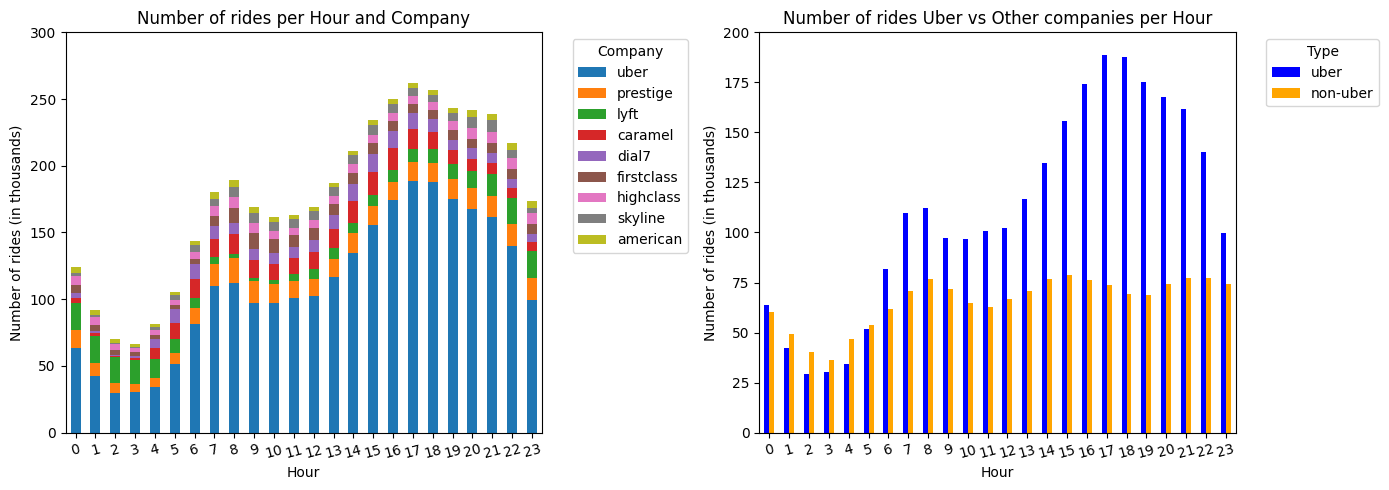

In [67]:
df.loc[df['company'] == 'uber', 'is-uber'] = 'uber'
df.loc[df['company'] != 'uber', 'is-uber'] = 'non-uber'

stacked_data = df.groupby(['hour', 'company']).size().unstack(fill_value=0)
stacked_data = stacked_data[stacked_data.sum(axis=0).sort_values(ascending=False).index]
non_stacked_data = df.groupby(['hour', 'is-uber']).size().unstack(fill_value=0)
non_stacked_data = non_stacked_data[non_stacked_data.sum(axis=0).sort_values(ascending=False).index]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

stacked_data.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_title("Number of rides per Hour and Company")
ax[0].set_xlabel("Hour")
ax[0].set_ylabel("Number of rides (in thousands)")
ax[0].legend(title="Company", bbox_to_anchor=(1.05, 1), loc='upper left')
ticks = ax[0].get_yticks()
ax[0].set_yticks(ticks)
ax[0].set_yticklabels([int(label / 1000) for label in ax[0].get_yticks()])
ax[0].tick_params(axis='x', rotation=15)

non_stacked_data.plot(kind='bar', ax=ax[1], color=['blue', 'orange'])
ax[1].set_title("Number of rides Uber vs Other companies per Hour")
ax[1].set_xlabel("Hour")
ax[1].set_ylabel("Number of rides (in thousands)")
ax[1].legend(title="Type", bbox_to_anchor=(1.05, 1), loc='upper left')
ticks = ax[1].get_yticks()
ax[1].set_yticks(ticks)
ax[1].set_yticklabels([int(label / 1000) for label in ax[1].get_yticks()])
ax[1].tick_params(axis='x', rotation=15)
plt.tight_layout()
plt.savefig('results/figures/fhv_companies_rides_per_hour.pdf', format='pdf')

plt.show()

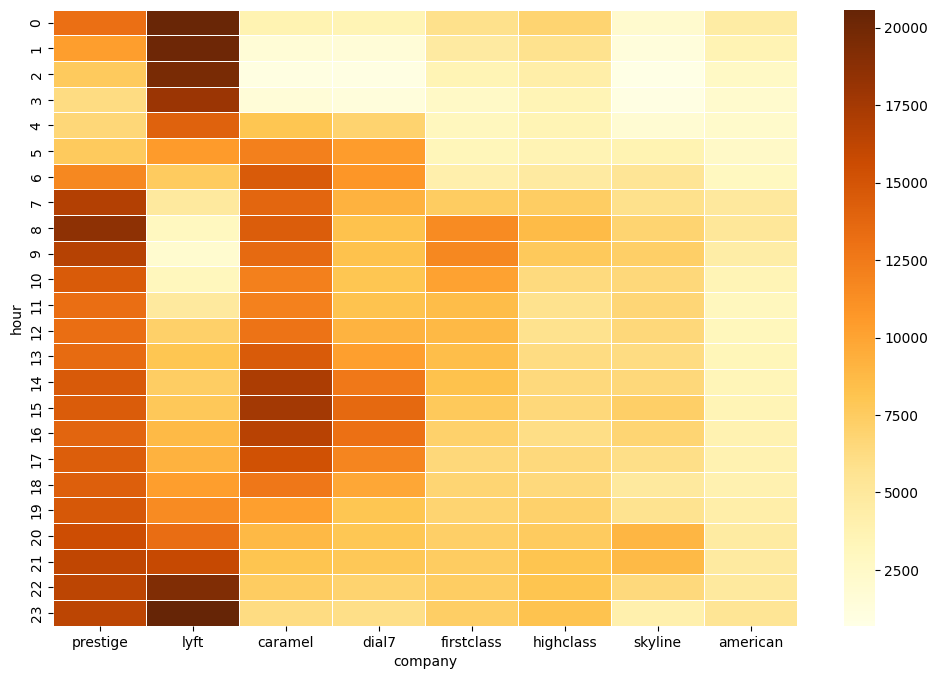

In [68]:
plt.figure(figsize = (12,8))

stacked_data_non_uber = stacked_data.drop(columns=['uber'])
ax = sns.heatmap(stacked_data_non_uber,cmap=cm.YlOrBr, linewidth = .5)

plt.show()

Lyft stands out with a significantly higher ride count during the early morning hours compared to the morning and afternoon, a pattern unique to the company. Additionally, between 1 AM and 5 AM, the number of rides on Uber is lower than for Non-Uber companies, suggesting a possible shortage of Uber drivers during those hours. In contrast, during the afternoon, Uber rides can exceed Non-Uber rides by more than double, highlighting Uber's dominance during peak daytime hours.